## Revelacion Data - Coding Challenge

#### Caracteristicas principales:

- Se propuso crear un modelo de machine learning para predecir diferentes modelos de motocicletas en el mercado.

- Las predicciones estaran basadas en imagenes.

- La idea es emular un sistema para reconocer vehiculos de la marca dentro de la fabrica o depositos y asi determinar estados de la linea de produccion, stock actual, cantidad de vehiculos producidos por hora, etc.

- Honda es la marca elegida para realizar las predicciones. Se utilizaran los principales 4 modelos de motocicleta del mercado:
    - Honda Biz 110
    - Honda Tornado 250
    - Honda CBR 1000
    - Honda Goldwing

- Las imagenes fueron extraidas de la web, la mayoria cuentan con licencia de uso publico pero puede que algunas posean licencia de uso privada, sin embargo para los fines de este challenge me tomo el atrevimiento de usar dicho dataset.

- Usando un complemento de Google Chrome se pudieron descargar batches de >200 imagenes a la vez. Sin embargo, fue necesario un curado de datos para eliminar las fotos no pertenecientes a la categoria.

- Se utilizaran 1000 imagenes por categoria, donde 800 seran destinadas al entrenamiento y 200 para la validacion. Ademas se genero otro conjunto de 52 imagenes (13 por categoria) para evaluar la performance del modelo con datos nunca vistos por el modelo.

### Library import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
from matplotlib.pyplot import figure

#---- CNN model libraries ----
import keras 
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


### Data preprocessing

- Data augmentation over the train dataset.
- Rescale to [0,1]
- Image reshape to 64x64 
- Batch size = 32 
- Greyscale color (due shape is more important  than color)

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

Dataset loading and transformation

In [3]:
image_width = 64
image_height = 64
color_channels = 1
data_classes = ['Tornado', 'CBR', 'Biz', 'Goldwing']

training_dataset = train_datagen.flow_from_directory('Dataset/Training/',
                                                    target_size = (image_width, image_height),
                                                    color_mode = 'grayscale',
                                                    batch_size = 32,
                                                    classes = data_classes,
                                                    class_mode = 'categorical')
testing_dataset = test_datagen.flow_from_directory('Dataset/Test/',
                                                        target_size = (image_width, image_height),
                                                        color_mode = 'grayscale',
                                                        batch_size = 32,
                                                        classes = data_classes,
                                                        class_mode = 'categorical')

validation_dataset = test_datagen.flow_from_directory('Dataset/validation/',
                                                        target_size = (image_width, image_height),
                                                        color_mode = 'grayscale',
                                                        batch_size = 52,
                                                        classes = data_classes, 
                                                        class_mode = None,
                                                        shuffle = False)

Found 3199 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Found 52 images belonging to 4 classes.


### CNN model build
Keras-based sequential model. Composed by the following layers:
- Convolutional layer #1
    - 32 Filters
    - Kernel size = 3
    - Image shape = 64x64
- Max pooling layer #1
    - Pooling size = 2
    - Strides window = 2
- Convolutional layer #2
    - 32 Filters
    - Kernel size = 3
- Max pooling layer #2
    - Pooling size = 2
    - Strides window = 2
- Flattening layer
- Fully connected hidden layer #1
    - 256 neurons
    - ReLu activation
- Fully connected hidden layer #2
    - 128 neurons
    - ReLu activation
- Output layer
    - 4 outputs (1 per class)
    - Sigmoid activation

In [5]:
classifier =  Sequential()
#Convolution layer
classifier.add( Conv2D(filters = 32, kernel_size = 3, 
                       input_shape = (image_width, image_height, color_channels), activation = 'relu' ) )
#Max pooling layer
classifier.add( MaxPooling2D(pool_size = 2, strides = 2) )

#Convolution layer
classifier.add( Conv2D(filters = 32, kernel_size = 3, 
                       activation = 'relu' ) )
#Max pooling layer
classifier.add( MaxPooling2D(pool_size = 2, strides = 2) )

#Flattening layer
classifier.add( Flatten() )

#Hidden layer 1
classifier.add( Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu') )
#Hidden layer 2
classifier.add( Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu') )

#Output layer
classifier.add( Dense(units = len(data_classes), kernel_initializer = 'uniform', activation = 'sigmoid') )

Final model specs:

In [6]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               1605888   
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
__________

Adam Optimizer with the following hyperparameters:

In [7]:
learning_rate = 0.0005
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-08
decay = 0.0

opt = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

CNN compile using the Adam optimizer and Binary crossentropy as loss function and accuracy as main metric.

In [9]:
classifier.compile( optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

#### Model training

In [10]:
train_len = 800
batch_size = 32
steps = train_len // batch_size

history = classifier.fit_generator(training_dataset,
                        steps_per_epoch = steps,
                        epochs = 100,
                        validation_data = testing_dataset,
                        validation_steps = steps )


Epoch 1/100
25/25 [==============================] - 12s 467ms/step - loss: 0.5949 - acc: 0.7381 - val_loss: 0.5734 - val_acc: 0.7500
Epoch 2/100
25/25 [==============================] - 9s 364ms/step - loss: 0.5702 - acc: 0.7500 - val_loss: 0.5642 - val_acc: 0.7500
Epoch 3/100
25/25 [==============================] - 10s 420ms/step - loss: 0.5648 - acc: 0.7500 - val_loss: 0.5624 - val_acc: 0.7500
Epoch 4/100
25/25 [==============================] - 10s 390ms/step - loss: 0.5599 - acc: 0.7500 - val_loss: 0.5579 - val_acc: 0.7500
Epoch 5/100
25/25 [==============================] - 10s 406ms/step - loss: 0.5490 - acc: 0.7500 - val_loss: 0.5405 - val_acc: 0.7500
Epoch 6/100
25/25 [==============================] - 11s 420ms/step - loss: 0.5263 - acc: 0.7538 - val_loss: 0.5209 - val_acc: 0.7594
Epoch 7/100
25/25 [==============================] - 11s 429ms/step - loss: 0.4999 - acc: 0.7678 - val_loss: 0.5099 - val_acc: 0.7538
Epoch 8/100
25/25 [==============================] - 10s 397ms

Metrics during training

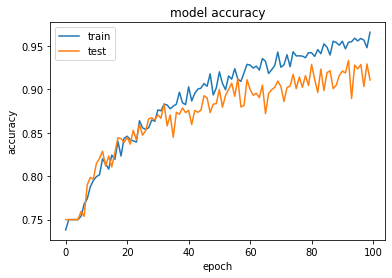

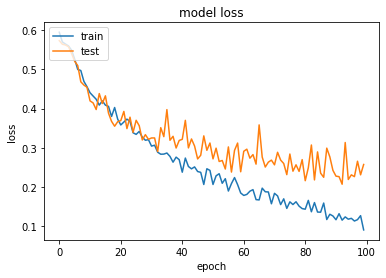

In [13]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model Performance Over Validation data

In [17]:
probabilities = classifier.predict_generator(validation_dataset, 1)

predicted_class_indices=np.argmax(probabilities,axis=1)
labels=(validation_dataset.class_indices)
labels2=dict((v,k) for k,v in labels.items())
predictions=[labels2[k] for k in predicted_class_indices]
print('Predictions: ', predictions)

Predictions:  ['Tornado', 'Tornado', 'Tornado', 'Tornado', 'CBR', 'Tornado', 'Tornado', 'Tornado', 'Tornado', 'Tornado', 'Goldwing', 'Tornado', 'Tornado', 'CBR', 'CBR', 'CBR', 'CBR', 'CBR', 'CBR', 'CBR', 'CBR', 'CBR', 'CBR', 'CBR', 'CBR', 'CBR', 'Biz', 'Tornado', 'Biz', 'Biz', 'Biz', 'Biz', 'CBR', 'CBR', 'Biz', 'Biz', 'Biz', 'Biz', 'Biz', 'Biz', 'Goldwing', 'Tornado', 'Goldwing', 'Goldwing', 'Goldwing', 'CBR', 'Goldwing', 'Goldwing', 'Goldwing', 'Goldwing', 'Goldwing', 'Goldwing']


Model performance:

In [19]:
from sklearn.metrics import confusion_matrix
y_test = predicted_class_indices
y_pred = validation_dataset.classes

confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Tornado', 'CBR', 'Biz', 'Goldwing']))

Confusion Matrix

[[11  0  1  1]
 [ 1 13  2  1]
 [ 0  0 10  1]
 [ 1  0  0 10]]

Accuracy: 0.85

Micro Precision: 0.85
Micro Recall: 0.85
Micro F1-score: 0.85

Macro Precision: 0.85
Macro Recall: 0.86
Macro F1-score: 0.84

Weighted Precision: 0.86
Weighted Recall: 0.85
Weighted F1-score: 0.85

Classification Report

              precision    recall  f1-score   support

     Tornado       0.85      0.85      0.85        13
         CBR       1.00      0.76      0.87        17
         Biz       0.77      0.91      0.83        11
    Goldwing       0.77      0.91      0.83        11

    accuracy                           0.85        52
   macro avg       0.85      0.86      0.84        52
weighted avg       0.86      0.85      0.85        52



# Predictions

Validation Dataset path reading

In [20]:
path = 'Dataset/Prueba/'
img_path = []
for count, filename in enumerate(os.listdir(path)):
    img_path.append(path + filename)

Prediction over validation data

In [22]:
predicted_images = []
predicted_labels = []
for path in img_path:
    image = tf.keras.preprocessing.image.load_img(path, color_mode= 'grayscale', 
                                                  target_size=(64,64),
                                                  interpolation= 'nearest')
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    predicted_class_indices=classifier.predict_classes(input_arr)
    labels=(validation_dataset.class_indices)
    labels2=dict((v,k) for k,v in labels.items())
    predictions=[labels2[k] for k in predicted_class_indices]
    
    image_to_show = tf.keras.preprocessing.image.load_img(path, color_mode= 'grayscale',
                                                          target_size=(256,256),
                                                          interpolation= 'nearest')
    predicted_images.append(image_to_show)
    predicted_labels.append(predictions[0])

Print predictions and images

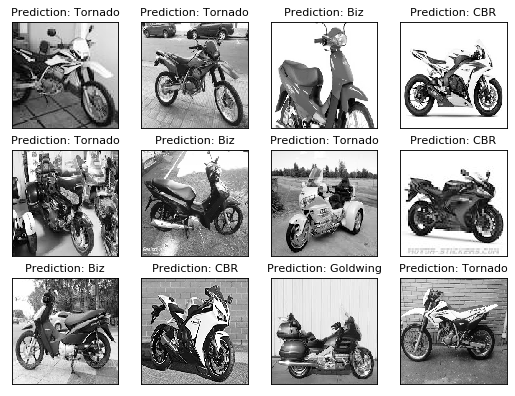

In [23]:
figure(figsize=(8, 6), dpi=80)
nrow = 3
ncols = 4
for i in range(12):
    plt.subplot(nrow, ncols, i+1)
    plt.imshow(predicted_images[i], cmap = 'Greys_r')
    plt.title('Prediction: '+str(predicted_labels[i]), fontsize = 10)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

### Model save

In [24]:
classifier.save('honda_classifier.H5')